In [1]:
import netCDF4 
from netCDF4 import Dataset
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 
import matplotlib.pyplot as plt
from math import pi
from numpy import cos,sin
from scipy.spatial import cKDTree



In [2]:
sub = "PHOS"
path = "MetO-NWS-BIO-dm-"+ sub+ ".nc"

nc_path = os.path.abspath(path); 
dataset = Dataset(nc_path)

subs2 = list(dataset.variables.keys())[0]
if(subs2 =='depth'):
    subs2 = list(dataset.variables.keys())[1]
    

#Interrogate netCDF file
print(dataset.file_format)
print(dataset.dimensions.keys()) #dimensions
print(dataset.dimensions['time'])
print(dataset.variables.keys()) #variables
print(dataset.variables[subs2]) #choose variable
print(dataset.Conventions) # Get conventions attribute

attr=dataset.ncattrs() #find all NetCDF global attributes  
# for attr in dataset.ncattrs():
#     print(attr, '=', getattr(dataset, attr))
  

NETCDF3_CLASSIC
dict_keys(['time', 'depth', 'latitude', 'longitude'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 7669
dict_keys(['depth', 'po4', 'latitude', 'time', 'longitude'])
<class 'netCDF4._netCDF4.Variable'>
int16 po4(time, depth, latitude, longitude)
    _FillValue: -32768
    scale_factor: 0.002
    add_offset: 50.0
    standard_name: mole_concentration_of_phosphate_in_sea_water
    long_name: Mole Concentration of Phosphate in Sea Water
    units: mmol m-3
    missing_value: -32768
    _ChunkSizes: [  1  24 375 297]
unlimited dimensions: 
current shape = (7669, 1, 76, 109)
filling on
CF-1.0


In [3]:
timestep=3800; #choose timestep
lon_lat_dim = 2

fh = Dataset(nc_path, mode='r')
time=fh.variables['time']
jd = netCDF4.num2date(time[:],time.units)
lons = fh.variables['longitude'][:]
lats = fh.variables['latitude'][:]

lons, lats = np.meshgrid(lons,lats)

Chlfa = fh.variables[subs2][:]
Chlfa = np.squeeze(Chlfa)
fh.close()


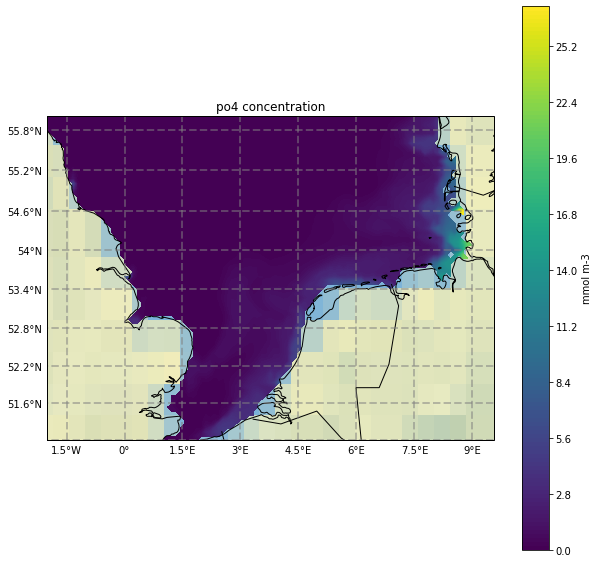

In [4]:
#PLOT
# Get some parameters for the Stereographic Projection
Chlfa_plot = Chlfa[timestep,:,:]

#Plot
matplotlib.rcParams['figure.figsize'] = (10,10) 

proj=ccrs.Mercator()
m = plt.axes(projection=proj)
# Put a background image on for nice sea rendering.
m.stock_img()
m.coastlines(resolution='10m')
m.add_feature(cfeature.BORDERS)
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
#Plot data
plt.contourf(lons, lats, Chlfa_plot, 150, 
             transform=ccrs.PlateCarree())

# plt.figure()
# Add Title
plt.title(subs2 +' concentration')

# Add Colorbar
cbar = plt.colorbar()
cbar.set_label(dataset.variables[subs2].units)

plt.show()


In [12]:
#Spatial subset loop

#region coordinates
ylat_north = 53.8;
ylat_south = 52.8;
xlon_east = 8;
xlon_west = 4.2;

chlfa_sub=np.full([int(Chlfa.shape[0]), int(Chlfa.shape[1]), int(Chlfa.shape[2])], np.nan)
lat_sub=np.full([int(Chlfa.shape[1]), int(Chlfa.shape[2])], np.nan)
lon_sub=np.full([int(Chlfa.shape[1]), int(Chlfa.shape[2])], np.nan)
for j in range(0,int(Chlfa.shape[2])):
    for i in range(0,int(Chlfa.shape[1])):
        #if the element by element lat and lons lie within the lat and lons specified for the region, then the indices for each point are saved in idxi and idxj, while the actual data itself is written to the 'domainrun' matrix (previously entirely filled with NaNs). This results in a matrix for the region, containing only the data for that specific subdomain along with NaNs everywhere else
        
        if lats[i,j]<=ylat_north and lats[i,j]>=ylat_south and lons[i,j]>=xlon_west and lons[i,j]<=xlon_east:
            #lat_sub and lon_sub contain the actual lat and lons for the subregion         
            lat_sub[i,j]=lats[i,j]
            lon_sub[i,j]=lons[i,j]
            chlfa_sub[:,i,j]=Chlfa[timestep,i,j]
        else:
            pass
        

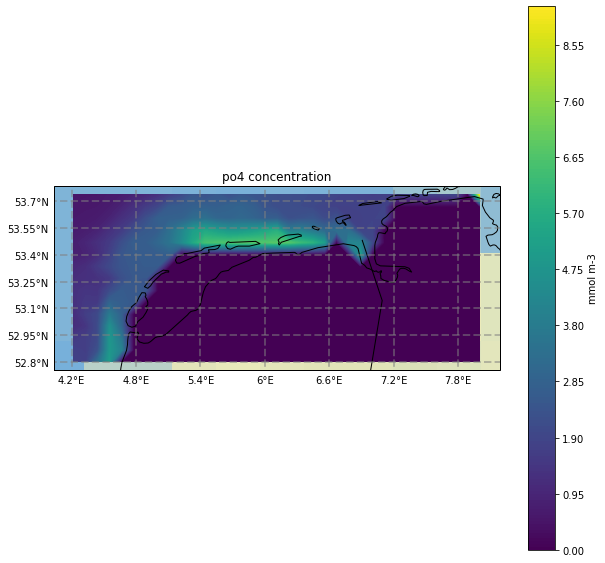

In [13]:
#PLOT SUBSET
#Plot
matplotlib.rcParams['figure.figsize'] = (10,10) 
            
proj=ccrs.Mercator()
m = plt.axes(projection=proj)
# Put a background image on for nice sea rendering.
m.stock_img()
m.coastlines(resolution='10m')
m.add_feature(cfeature.BORDERS)
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

#Plot data
plt.contourf(lon_sub, lat_sub, chlfa_sub[timestep,:,:], 200,
             transform=ccrs.PlateCarree())

# Add Colorbar
cbar = plt.colorbar()
cbar.set_label(dataset.variables[subs2].units)

# Add Title
plt.title(subs2 +' concentration')

plt.show()


Exact Location lat-lon: [52.983622, 4.75027]
Closest lat-lon: 53.00065 4.77753
Array indices [iy,ix]= 30 61
[cftime.DatetimeGregorian(1998-01-01 12:00:00)
 cftime.DatetimeGregorian(1998-01-02 12:00:00)
 cftime.DatetimeGregorian(1998-01-03 12:00:00) ...
 cftime.DatetimeGregorian(2018-12-28 12:00:00)
 cftime.DatetimeGregorian(2018-12-29 12:00:00)
 cftime.DatetimeGregorian(2018-12-30 12:00:00)]


ConversionError: Failed to convert value(s) to axis units: array([cftime.DatetimeGregorian(1998-01-01 12:00:00),
       cftime.DatetimeGregorian(1998-01-02 12:00:00),
       cftime.DatetimeGregorian(1998-01-03 12:00:00), ...,
       cftime.DatetimeGregorian(2018-12-28 12:00:00),
       cftime.DatetimeGregorian(2018-12-29 12:00:00),
       cftime.DatetimeGregorian(2018-12-30 12:00:00)], dtype=object)

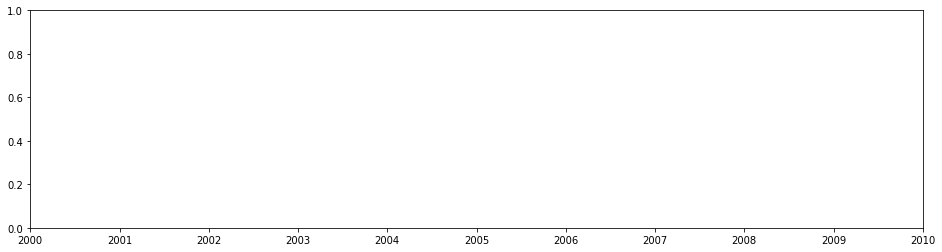

In [16]:
# # Get time series at given location

# # Get time series at given location
# loni = 4.75027 
# lati = 52.983622

# #Choose option whether your lon/lat data is 1D or 2D
# ##Option 1: if lon/lat is 1D array
# #
# ##Gives the correct id number of lat and lon of the closest point
# #from numpy import absolute as abs
# #loni = 1.431376773443956
# #lati = 40.78784986878748
# #
# #my_point = {'name': 'My_point', 'lat': lati, 'lon': loni}
# #
# ## Find the nearest latitude and longitude for Darwin
# #lat_idx = np.abs(lats - my_point['lat']).argmin()
# #lon_idx = np.abs(lons - my_point['lon']).argmin()
# #
# #print ('Exact Location lat-lon:', [lati,loni])
# #print ('Closest lat-lon:', lats[lat_idx], lons[lon_idx])
# #print ('Array indices [iy,ix]=', lat_idx, lon_idx)    
# #
# ## it works! 
# ##iy = lat_idx
# ##ix = lon_idx
# #h = North_vel[:,0,lat_idx,lon_idx]
# #plt.figure(figsize=(16,4))
# #plt.plot_date(jd,h,fmt='-')
# #plt.grid()
# #plt.ylabel(dataset.variables['vo'].units)

# #Option2: if lon/lat is 2D array
# #Looking up array indices using KD-Tree 

# def kdtree_fast (lats, lons, lat_0, lon_0):
#         rad_factor= pi/180.0 #for trignometry, need angles in radians
#         # Read Lat,Long from file to numpy arrays
#         latvals= lats[:]*rad_factor
#         lonvals= lons[:]*rad_factor
#         ny,nx = latvals.shape
#         clat,clon = cos(latvals),cos(lonvals)
#         slat,slon = sin(latvals),sin(lonvals)
#         # Build kd-tree from big arrays of 3D coordinates
#         triples = list(zip(np.ravel(clat*clon), np.ravel(clat*slon), np.ravel(slat)))
#         kdt = cKDTree(triples)
#         lat0_rad = lat_0 * rad_factor
#         lon0_rad = lon_0 * rad_factor
#         clat0,clon0 = cos(lat0_rad),cos(lon0_rad)
#         slat0,slon0 = sin(lat0_rad),sin(lon0_rad)
#         dist_sq_min, minindex_1d = kdt.query([clat0*clon0, clat0*slon0, slat0])
#         iy_min, ix_min = np.unravel_index(minindex_1d, latvals.shape)
#         return iy_min,ix_min

# # iy,ix = kdtree_fast(lats, lons, lati, loni)
# # print ('Exact Location lat-lon:', [lati,loni])
# # print ('Closest lat-lon:', lats[iy,ix], lons[iy,ix])
# # print ('Array indices [iy,ix]=', iy, ix)    
                
# # #Get all time records of variable [vname] at indices [iy,ix]
# # h = Chlfa[:,iy,ix]

# # #Plot ime series
# # plt.figure(figsize=(16,4))
# # plt.plot_date(jd,h,fmt='-')
# # plt.grid()

# iy,ix = kdtree_fast(lats, lons, lati, loni)
# print ('Exact Location lat-lon:', [lati,loni])
# print ('Closest lat-lon:', lats[iy,ix], lons[iy,ix])
# print ('Array indices [iy,ix]=', iy, ix)    

# #Get all time records of variable [vname] at indices [iy,ix]
# h = Chlfa[:,ix,iy]

# print(jd)
# #Plot ime series
# plt.figure(figsize=(16,4))
# plt.plot_date(jd,h,fmt='-')
# plt.grid()
# plt.ylabel(dataset.variables[subs2].units)
# plt.title('%s at Lon=%.2f, Lat=%.2f' % (subs2, lons[iy, ix], lats[iy, ix]))

In [6]:
import gudhi as gdi


gdi.Sparse_rips_complex(Chlfa[timestep,:,:])

AttributeError: module 'gudhi' has no attribute 'Sparse_rips_complex'